In [7]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Static Variables

In [8]:
line = "46A"

### Reading Data

In [9]:
df = pd.read_csv("bus_data/line_data/" + line + ".csv", low_memory=False, header=None)
df.columns = ["Timestamp", "LineID", "JourneyPatternID", "TimeFrame", 
              "VehicleJourneyID", "Lon", "Lat", "VehicleID", "StopID", 
              "AtStop", "HumanTime", "Day", "Hour", "Runtime"]

#convert StopID to string

df['StopID'] = df['StopID'].astype('str')


df.head()

,Timestamp,LineID,JourneyPatternID,TimeFrame,VehicleJourneyID,Lon,Lat,VehicleID,StopID,AtStop,HumanTime,Day,Hour,Runtime
0,1352160071000000,46A,1,2012-11-05,7429,-6.164383,53.278118,33540,2021,1,2012-11-06 00:01:11,1,0,0
1,1352160114000000,46A,1,2012-11-05,7429,-6.161541,53.280006,33540,2022,1,2012-11-06 00:01:54,1,0,43
2,1352160173000000,46A,1,2012-11-05,7429,-6.155130,53.281273,33540,4565,1,2012-11-06 00:02:53,1,0,102
3,1352160432000000,46A,1,2012-11-05,7429,-6.142574,53.295757,33540,2035,1,2012-11-06 00:07:12,1,0,361
4,1352160578000000,46A,1,2012-11-05,7429,-6.138210,53.295761,33540,2036,1,2012-11-06 00:09:38,1,0,507


### Getting Stop Locations

In [10]:
# # Isolating variations - getting variation with most stops

patterns = df['JourneyPatternID'].unique()

for pattern in patterns:
    print(pattern)

1
1001
1003
8
1006
1004
1005
5
4
3
1002
2


In [11]:
# Concat location data

df['location'] = ""
df['location'] = df['Lon'].astype(str) + "_" + df['Lat'].astype(str)

In [12]:
# Getting biggest pattern

max_pattern = df['JourneyPatternID'].value_counts().idxmax()
new_df = df[df.JourneyPatternID == max_pattern]

In [13]:
# cutting stops that don't appear more than 20 times

groups = new_df.groupby('StopID')
new_df = groups.filter(lambda x: len(x) > 20)


In [14]:
new_df.head()

,Timestamp,LineID,JourneyPatternID,TimeFrame,VehicleJourneyID,Lon,Lat,VehicleID,StopID,AtStop,HumanTime,Day,Hour,Runtime,location
7,1352182202000000,46A,1001,2012-11-06,7220,-6.147297,53.282879,36031,4568,1,2012-11-06 06:10:02,1,6,475,-6.147297_53.282879
10,1352182407000000,46A,1001,2012-11-06,7231,-6.135499,53.292816,36032,2040,1,2012-11-06 06:13:27,1,6,221,-6.135499_53.292816
14,1352182688000000,46A,1001,2012-11-06,7220,-6.189715,53.280312,36031,2063,1,2012-11-06 06:18:08,1,6,961,-6.189715_53.280312
17,1352182749000000,46A,1001,2012-11-06,7220,-6.193758,53.282814,36031,2064,1,2012-11-06 06:19:09,1,6,1022,-6.193758_53.282814
19,1352182788000000,46A,1001,2012-11-06,7220,-6.194721,53.284836,36031,2065,1,2012-11-06 06:19:48,1,6,1061,-6.194721_53.284836


In [15]:
groups = new_df.groupby('StopID')

In [16]:
# Extracting the most frequent locations for each stop
loc_df = groups['location'].agg(lambda x:x.value_counts().index[0]).to_frame()
loc_df.reset_index(level=0, inplace=True)

# Converting location back to float columns
loc_df['Lon'], loc_df['Lat'] = loc_df['location'].str.split('_', 1).str
loc_df['Lon'], loc_df['Lat'] = loc_df['Lon'].astype('float64'), loc_df['Lat'].astype('float64')

# drop concatenated colum 'location'
loc_df = loc_df.drop('location', axis=1)
loc_df.head()

,StopID,Lon,Lat
0,192,-6.268058,53.356480
1,2,-6.263668,53.352280
2,2039,-6.134798,53.294781
3,2040,-6.135499,53.292816
4,2041,-6.139282,53.293621


### Cleaned location data vs raw location data

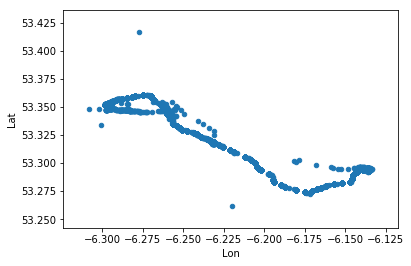

In [22]:
# Raw

locations = new_df[["Lon", "Lat"]]
locations.plot.scatter(x="Lon", y="Lat")

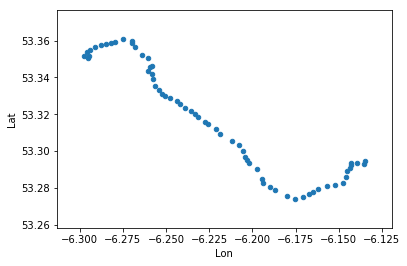

In [23]:
# Clean

locations = loc_df[["Lon", "Lat"]]
locations.plot.scatter(x="Lon", y="Lat")

### Getting Stop Orders

In [24]:
runtimes = new_df.groupby("StopID").Runtime.mean()

order = runtimes.sort_values().to_frame()
order.reset_index(level=0, inplace=True)
order['Order'] = order.index

### Merging dataframes and saving results

In [30]:
# adding LineID and JourneyPatternID

line_df = df[["LineID", "JourneyPatternID", "StopID"]]
line_df = line_df.drop_duplicates()
line_df.shape

(516, 3)

In [31]:
static_stops = pd.merge(order, loc_df, line_df, on='StopID')
static_stops.shape

TypeError: Could not compare ['left'] with block values

(516, 3)

In [32]:
static_stops = pd.merge(static_stops, line_df, on="StopID" )

In [27]:
# static_stops.to_csv('bus_data/static_data/routestops' + line + '.csv')

In [33]:
static_stops.head()

,StopID,Runtime,Order,Lon,Lat,LineID,JourneyPatternID
0,2039,117.862915,0,-6.134798,53.294781,46A,1
1,2039,117.862915,0,-6.134798,53.294781,46A,1001
2,2039,117.862915,0,-6.134798,53.294781,46A,8
3,2039,117.862915,0,-6.134798,53.294781,46A,5
4,2039,117.862915,0,-6.134798,53.294781,46A,4
